## Cloudless Mosaic

This tutorial constructs a *cloudless mosaic* (also known as a composite) from a time series of satellite images. We'll see the following:

* Find a time series of images at a particular point on Earth
* Stack those images together into a single array
* Compute the cloudless mosaic by taking a median
* Visualize the results

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques used here apply equally well to other remote-sensing datasets.

In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

import geopandas as gpd

### Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [5]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.bb933e193da642edb9d4acac1cc96043/status


### Discover data

In this example, we define our area of interest as a GeoJSON object. It's near Redmond, Washington.

In [6]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}
bbox = rasterio.features.bounds(area_of_interest)

In [7]:
# Change the AOI to Vanatu, get the bounding box
# Fiji would be nice but we'd need to deal with the Anti Meridian 
countries = gpd.read_file("../pic_countries.geojson")
bbox = countries[countries["ISO"] == 'VUT'].bounds.iloc[0].to_list()


In [8]:
bbox

[166.52051842500012,
 -20.253106377999913,
 169.89893639400023,
 -13.064873955999843]

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [10]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

#Reduce the time window to reduce data, 6411 items is too much for demo.
search = stac.search(
    bbox=bbox,
    #datetime="2016-01-01/2020-12-31",
    datetime="2020-06-01/2020-09-30",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 5}},
)

items = list(search.get_items())
print(len(items))

103


So 138 items match our search requirements, over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [11]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [12]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B04", "B03", "B02"],  # red, green, blue
        chunksize=4096,
        resolution=100,
        epsg=32759, #pick 1 of the utm zones to align everything
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

,Array,Chunk
Bytes,97.31 GiB,128.00 MiB
Shape,"(103, 3, 9149, 4620)","(1, 1, 4096, 4096)"
Count,6186 Tasks,1854 Chunks
Type,float64,numpy.ndarray


Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [13]:
data = data.persist() # Vanatu example might be too big

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are transient, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

This will be computed in parallel on the cluster (make sure to open the Dask Dashboard using the link printed out above).

In [14]:
median = data.median(dim="time").compute()

To visualize the data, we'll use xarray-spatial's `true_color` method to convert to red/green/blue values.

In [15]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

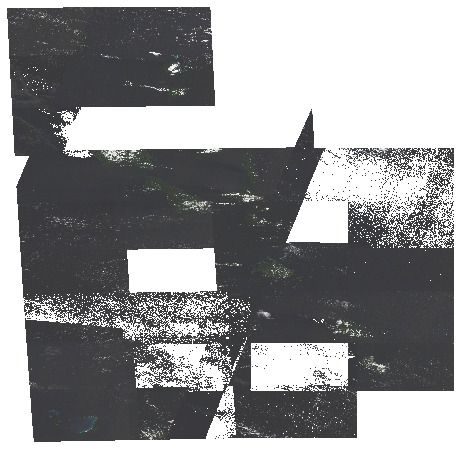

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
image.plot.imshow(ax=ax);

### Monthly composite

Now suppose we don't want to combine images from different parts of the year (for example, we might not want to combine images from January that often include snow with images from July). Again using standard xarray syntax, we can create set of per-month composites by grouping by month and then taking the median.

In [17]:
monthly = data.groupby("time.month").median().compute()

Let's convert each of those arrays to a true-color image and plot the results as a grid.

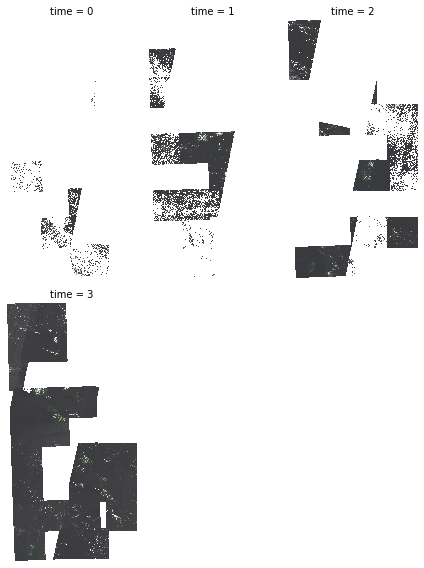

In [18]:
images = [ms.true_color(*x) for x in monthly]
images = xr.concat(images, dim="time")

g = images.plot.imshow(x="x", y="y", rgb="band", col="time", col_wrap=3, figsize=(6, 8))
for ax in g.axes.flat:
    ax.set_axis_off()

plt.tight_layout()

### Save the results

You'll need a SAS token to write to Blob storage container.
Then loop over monthly saving each month as a Cloud Optimized Geotiff.

In [25]:
import rioxarray

In [31]:
images.shape

(4, 9149, 4620, 4)

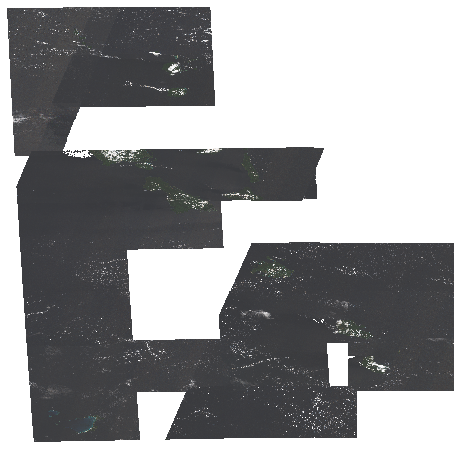

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

In [40]:
# for each time
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
images[3,].plot.imshow(ax=ax, rgb="band")
images[3,].to_raster()

### Learn more

To learn more about using the the Planetary Computer's STAC API, see [Reading data from the STAC API](../quickstarts/reading-stac.ipynb). To learn more about Dask, see [Scaling with Dask](../quickstarts/scale-with-dask.ipynb).